# Notebook that handles fine-tuning from start to finish

In [3]:
# # !pip install "sagemaker>=2.140.0" "transformers==4.26.1" "datasets[s3]==2.10.1" --upgrade
# # !pip install git+https://github.com/huggingface/transformers.git

# !pip install transformers datasets[s3] sagemaker --upgrade
# !pip install scikit-learn
# !pip install accelerate==0.20.3

In [2]:
import numpy as np
from sagemaker import get_execution_role
import boto3
import pandas as pd
from io import StringIO # Python 3.
from datasets import load_dataset,Dataset,DatasetDict,concatenate_datasets

from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput
import torch
import torch.nn as nn
import pandas as pd
import json

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data we will be working with

In [3]:
bucket_name = 'chianglab-dataderivatives'
file_path = "mimic-iv-ed-2.2/text_repr.json"

s3 = boto3.resource('s3')
content_object = s3.Object(bucket_name, file_path)
file_content = content_object.get()['Body'].read().decode('utf-8')
json_content = json.loads(file_content)
df = pd.DataFrame(json_content).T
print("length of dataframe: "+ str(len(df)))
df.head(5)
# df['codes_headline'] = df['ID'].map(json_content)


length of dataframe: 400019


,arrival,eddischarge,admission,discharge,eddischarge_category,triage,medrecon,vitals,codes,pyxis
33258284,"Patient 10000032, a 52 year old white female, ...",The ED disposition was admitted at 2180-05-06 ...,The patient was admitted at 2180-05-06 22:23:00.,The patient's discharge disposition was: home ...,a d m i t t e d,"At triage: temperature was 98.4, pulse was 70....",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,NaN
38112554,"Patient 10000032, a 52 year old white female, ...",The ED disposition was admitted at 2180-06-26 ...,The patient was admitted at 2180-06-26 18:27:00.,The patient's discharge disposition was: home ...,a d m i t t e d,"At triage: temperature was 98.9, pulse was 88....",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient received the following medications...
35968195,"Patient 10000032, a 52 year old white female, ...",The ED disposition was admitted at 2180-08-06 ...,The patient was admitted at 2180-08-05 23:44:00.,The patient's discharge disposition was: hospi...,a d m i t t e d,"At triage: temperature was 99.4, pulse was 105...",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient received the following medications...
32952584,"Patient 10000032, a 52 year old white female, ...",The ED disposition was home at 2180-07-23 05:5...,The patient was admitted at 2180-07-23 12:35:00.,The patient's discharge disposition was: home ...,h o m e,"At triage: temperature was 97.8, pulse was 87....",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient received the following medications...
39399961,"Patient 10000032, a 52 year old white female, ...",The ED disposition was admitted at 2180-07-23 ...,The patient was admitted at 2180-07-23 12:35:00.,The patient's discharge disposition was: home ...,a d m i t t e d,"At triage: temperature was 98.7, pulse was 77....",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient received the following medications...


In [4]:
df['eddischarge'] = [1 if 'admitted' in s.lower() else 0 for s in df['eddischarge']] # admitted = 1, Home = 0
df['medrecon'] = df['medrecon'].fillna("The patient was previously not taking any medications.")
df['pyxis'] = df['pyxis'].fillna("The patient did not receive any medications.")
df['vitals'] = df['vitals'].fillna("The patient had no vitals recorded")
df['codes'] = df['codes'].fillna("The patient received no diagnostic codes")
df = df.drop("admission",axis=1)
df = df.drop("discharge",axis=1)
df = df.drop("eddischarge_category",axis=1)
df['ID'] = df.arrival.astype(str).str.split().str[1].replace(",", " ", regex=True).to_list()
df = df[[col for col in df.columns if col != 'eddischarge'] + ['eddischarge']] # rearrange column to the end
df

# remove admission and discharge columns 

,arrival,triage,medrecon,vitals,codes,pyxis,ID,eddischarge
33258284,"Patient 10000032, a 52 year old white female, ...","At triage: temperature was 98.4, pulse was 70....",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient did not receive any medications.,10000032,1
38112554,"Patient 10000032, a 52 year old white female, ...","At triage: temperature was 98.9, pulse was 88....",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient received the following medications...,10000032,1
35968195,"Patient 10000032, a 52 year old white female, ...","At triage: temperature was 99.4, pulse was 105...",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient received the following medications...,10000032,1
32952584,"Patient 10000032, a 52 year old white female, ...","At triage: temperature was 97.8, pulse was 87....",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient received the following medications...,10000032,0
39399961,"Patient 10000032, a 52 year old white female, ...","At triage: temperature was 98.7, pulse was 77....",The patient was previously taking the followin...,The patient had the following vitals: At 2180-...,The patient received the following diagnostic ...,The patient received the following medications...,10000032,1
...,...,...,...,...,...,...,...,...
34149746,"Patient 19999784, a 57 year old black/african ...","At triage: temperature was 98.8, pulse was 92....",The patient was previously taking the followin...,The patient had the following vitals: At 2119-...,The patient received the following diagnostic ...,The patient received the following medications...,19999784,1
35692999,"Patient 19999784, a 57 year old black/african ...","At triage: temperature was 98.6, pulse was 80....",The patient was previously not taking any medi...,The patient had the following vitals: At 2119-...,The patient received the following diagnostic ...,The patient did not receive any medications.,19999784,1
32917002,"Patient 19999828, a 46 year old white female, ...","At triage: temperature was 96.6, pulse was 112...",The patient was previously taking the followin...,The patient had the following vitals: At 2149-...,The patient received the following diagnostic ...,The patient received the following medications...,19999828,1
30712109,"Patient 19999828, a 46 year old white female, ...","At triage: temperature was 98.1, pulse was 83....",The patient was previously taking the followin...,The patient had the following vitals: At 2147-...,The patient received the following diagnostic ...,The patient received the following medications...,19999828,1


In [5]:
# split dataframe here
def train_validate_test_split(df, train_percent=.7, validate_percent=.15, seed=None):
    np.random.seed(seed)
    df = df.reset_index()
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    train = train.set_index('index')
    validate = validate.set_index('index')
    test = test.set_index('index')
    return train, validate, test

In [7]:
t, val, t2 = train_validate_test_split(df, train_percent=.9, validate_percent=.05, seed=7)
print("70% Train:",len(t), "\n30% Test:",len(val+t2))

remain = pd.concat([val, t2])
print("Size of validation + test after concat: ", len(remain)) # sanity check

# #resplit the our testing dataframe into an additional train and test split for fine tuning 
train, validate, test =  train_validate_test_split(remain, seed=7)
print("70% Train:",len(train), "\n30% Test:",len(validate+test))

70% Train: 360017 
30% Test: 40002
Size of validation + test after concat:  40002
70% Train: 28001 
30% Test: 12001


In [9]:
def cut(df, set_type):
    col_names = df.columns.drop("eddischarge")
    l = []
    for i in col_names:
        temp = df[[i, 'eddischarge']].reset_index()
        temp = temp.sort_values(by=['index']).reset_index() # we sort the patient ID numerically before dropping it to preserve order in encoding
        temp = temp.drop(columns=["index", "level_0"])
        temp = temp.rename(columns={i: "headline", "eddischarge": "label"})
        l.append(temp)
        print("\""+i+ "\" Dataframe:", set_type, "set has been split")
    return l

print("################################################")
l1 = cut(train, "train")
print("################################################")
l2 = cut(validate, "validation")
print("################################################")
l3 = cut (test, "test")
print("################################################")

################################################
"arrival" Dataframe: train set has been split
"triage" Dataframe: train set has been split
"medrecon" Dataframe: train set has been split
"vitals" Dataframe: train set has been split
"codes" Dataframe: train set has been split
"pyxis" Dataframe: train set has been split
"ID" Dataframe: train set has been split
################################################
"arrival" Dataframe: validation set has been split
"triage" Dataframe: validation set has been split
"medrecon" Dataframe: validation set has been split
"vitals" Dataframe: validation set has been split
"codes" Dataframe: validation set has been split
"pyxis" Dataframe: validation set has been split
"ID" Dataframe: validation set has been split
################################################
"arrival" Dataframe: test set has been split
"triage" Dataframe: test set has been split
"medrecon" Dataframe: test set has been split
"vitals" Dataframe: test set has been split
"codes" Datafra

In [10]:
from transformers import TextClassificationPipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
# tokenize
model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

class Tokenizer():
    def tokenize(self,examples):
      """Mapping function to tokenize the sentences passed with truncation"""
      return tokenizer(examples["headline"], truncation=True, padding="max_length",
                        max_length=512, return_special_tokens_mask=True)
    def convert(self, l):
        """
        Run this method
        """
        arrival_hf=Dataset.from_pandas(l[0])
        triage_hf=Dataset.from_pandas(l[1])
        medrecon_hf=Dataset.from_pandas(l[2])
        vitals_hf=Dataset.from_pandas(l[3])
        codes_hf=Dataset.from_pandas(l[4])
        pyxis_hf=Dataset.from_pandas(l[5])

        arrival = arrival_hf.map(self.tokenize, batched=True)
        triage = triage_hf.map(self.tokenize, batched=True)
        medrecon = medrecon_hf.map(self.tokenize, batched=True)
        vitals = vitals_hf.map(self.tokenize, batched=True)
        codes = codes_hf.map(self.tokenize, batched=True)
        pyxis = pyxis_hf.map(self.tokenize, batched=True)
        
        print(arrival)

        arrival.set_format('torch', columns=["input_ids", "attention_mask", "label"] )
        triage.set_format('torch', columns=["input_ids", "attention_mask", "label"] )
        medrecon.set_format('torch', columns=["input_ids", "attention_mask", "label"] )
        vitals.set_format('torch', columns=["input_ids", "attention_mask", "label"] )
        codes.set_format('torch', columns=["input_ids", "attention_mask", "label"] )
        pyxis.set_format('torch', columns=["input_ids", "attention_mask", "label"] )

        return arrival, triage, medrecon, vitals, codes, pyxis
    
# calls methods and tokenizes text
processor = Tokenizer()
arrival_train_tokens, triage_train_tokens, medrecon_train_tokens, vitals_train_tokens, codes_train_tokens, pyxis_train_tokens, = processor.convert(l1)
arrival_val_tokens, triage_val_tokens, medrecon_val_tokens, vitals_val_tokens, codes_val_tokens, pyxis_val_tokens, = processor.convert(l2)
arrival_test_tokens, triage_test_tokens, medrecon_test_tokens, vitals_test_tokens, codes_test_tokens, pyxis_test_tokens, = processor.convert(l3)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map: 100%|██████████| 28001/28001 [00:05<00:00, 5498.39 examples/s]


Dataset({
    features: ['headline', 'label', 'input_ids', 'attention_mask', 'special_tokens_mask'],
    num_rows: 28001
})


Map: 100%|██████████| 6000/6000 [00:01<00:00, 5711.45 examples/s]


Dataset({
    features: ['headline', 'label', 'input_ids', 'attention_mask', 'special_tokens_mask'],
    num_rows: 6000
})


Map: 100%|██████████| 6001/6001 [00:01<00:00, 5662.27 examples/s]

Dataset({
    features: ['headline', 'label', 'input_ids', 'attention_mask', 'special_tokens_mask'],
    num_rows: 6001
})


In [11]:
arrival_dataset_cc = DatasetDict({
    'train': arrival_train_tokens,
    'test': arrival_test_tokens,
    'valid': arrival_val_tokens})

triage_dataset_cc = DatasetDict({
    'train': triage_train_tokens,
    'test': triage_test_tokens,
    'valid': triage_val_tokens})

medrecon_dataset_cc = DatasetDict({
    'train': medrecon_train_tokens,
    'test': medrecon_test_tokens,
    'valid': medrecon_val_tokens})

vitals_dataset_cc = DatasetDict({
    'train': vitals_train_tokens,
    'test': vitals_test_tokens,
    'valid': vitals_val_tokens})

codes_dataset_cc = DatasetDict({
    'train': codes_train_tokens,
    'test': codes_test_tokens,
    'valid': codes_val_tokens})

pyxis_dataset_cc = DatasetDict({
    'train': pyxis_train_tokens,
    'test': pyxis_test_tokens,
    'valid': pyxis_val_tokens})

In [13]:
class EDdispositionClassifier(nn.Module):
    """
    A task-specific custom transformer model for predicting ED Disposition. 
    This model loads a pre-trained transformer model and adds a new dropout 
    and linear layer at the end for fine-tuning and prediction on specific tasks.
    """
    def __init__(self, checkpoint, num_labels):
        """
        Args:
            checkpoint (str): The name of the pre-trained model or path to the model weights.
            num_labels (int): The number of output labels in the final classification layer.
        """
        super(EDdispositionClassifier, self).__init__()
        self.num_labels = num_labels # number of labels for classifier
        
        # checkpoint is the model name 
        self.model = model = AutoModel.from_pretrained(checkpoint, config = AutoConfig.from_pretrained(checkpoint, 
                                                                                                       output_attention = True, 
                                                                                                       output_hidden_state = True ) )
        # New Layer
        self.dropout = nn.Dropout(0.1) # to prevent overfittting
        self.classifier = nn.Linear(768, num_labels) #FC Layer - takes in a 768 token vector and is a Linear classifier with n labels
        
    def forward(self, input_ids = None, attention_mask=None, labels = None ):
        """
        Forward pass for the model.
        
        Args:
            input_ids (torch.Tensor, optional): Tensor of input IDs. Defaults to None.
            attention_mask (torch.Tensor, optional): Tensor for attention masks. Defaults to None.
            labels (torch.Tensor, optional): Tensor for labels. Defaults to None.
            
        Returns:
            TokenClassifierOutput: A named tuple with the following fields:
            - loss (torch.FloatTensor of shape (1,), optional, returned when label_ids is provided) – Classification loss.
            - logits (torch.FloatTensor of shape (batch_size, num_labels)) – Classification scores before SoftMax.
            - hidden_states (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True is passed or when config.output_hidden_states=True) – Tuple of torch.FloatTensor (one for the output of the embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size).
            - attentions (tuple(torch.FloatTensor), optional, returned when output_attentions=True is passed or when config.output_attentions=True) – Tuple of torch.FloatTensor (one for each layer) of shape (batch_size, num_heads, sequence_length, sequence_length).
        """
        # calls on the Automodel to deploy correct model - in our case distilled-bert-uncased
        outputs = self.model(input_ids = input_ids, attention_mask = attention_mask  )
        
        # retrieves the last hidden state
        last_hidden_state = outputs[0]
        
        return last_hidden_state # The embedding
        
class SelfAttentionPlus(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttentionPlus, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        self.num_labels = 2 # number of labels for classifier
        self.dropout = nn.Dropout(0.1) # to prevent overfittting
        self.classifier = nn.Linear(768, 2) #FC Layer - takes in a 768 token vector and is a Linear classifier with n labels
        self.dense_layer = nn.Linear(768, 768)
        self.loss_func = nn.CrossEntropyLoss() # Change this if it becomes more than binary classification

    def forward(self, x, labels = None):
        # typical self attention workflow
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        attention = self.softmax(scores)
        weighted = torch.bmm(attention, values)
    
        # project brand new layers into 768 dimensions 
        new_vec = self.dense_layer(weighted)
        
        # begin classification
        # self.dropout = nn.Dropout(0.1) # to prevent overfittting
        # self.classifier = nn.Linear(768, 2) #FC Layer - takes in a 768 token vector and is a Linear classifier with n labels
    
        # include dropout from constructor to feed forward network
        sequence_outputs = self.dropout(new_vec)
        # finally add linear layer from input
        logits = self.classifier(sequence_outputs[:, 0, : ].view(-1, 768 ))
        
        # calculates loss 
        loss = None
        if labels is not None:
            loss = self.loss_func(logits.view(-1, self.num_labels), labels.view(-1))
            
            # TokenClassifierOutput - returns predicted label
            return TokenClassifierOutput(loss=loss, logits=logits)#, hidden_states=outputs.hidden_states, attentions=new_vec.attentions)
        
        else:
            return logits
        
class EDDispositionFineTuneModel(nn.Module):
    def __init__(self, checkpoint, num_labels=2, input_dim=768, modalities=None):
        super(EDDispositionFineTuneModel, self).__init__()
        self.encoder = EDdispositionClassifier(checkpoint=checkpoint, num_labels=num_labels)
        self.predictor = SelfAttentionPlus(input_dim=input_dim)
        assert modalities is not None, "Number of modalities missing"
        self.modalities = modalities
    
    def forward(self, input_ids, attention_mask, label=None):
        # input_ids: dictionary of the batch
        # attention_mask: dictionary of the batch
        embedding = []
        for modality in range(self.modalities):
            embed = self.encoder(input_ids[modality], attention_mask[modality], label)
            embedding.append(embed)
        unified_embedding = torch.cat((embedding[0],embedding[1],embedding[2],embedding[3],embedding[4],embedding[5]),1) # concatenates embeddings on the second dimension
        outputs = self.predictor(unified_embedding, label)
        return outputs

In [14]:
class SingleModPredictor(nn.Module):
    """
    A task-specific custom transformer model for predicting ED Disposition. 
    This model loads a pre-trained transformer model and adds a new dropout 
    and linear layer at the end for fine-tuning and prediction on specific tasks.
    """
    def __init__(self, checkpoint, num_labels ):
        """
        Args:
            checkpoint (str): The name of the pre-trained model or path to the model weights.
            num_labels (int): The number of output labels in the final classification layer.
        """
        super(SingleModPredictor, self).__init__()
        self.num_labels = num_labels # number of labels for classifier
        
        # checkpoint is the model name 
        self.model = model = AutoModel.from_pretrained(checkpoint, config = AutoConfig.from_pretrained(checkpoint, 
                                                                                                       output_attention = True, 
                                                                                                       output_hidden_state = True ) )
        # New Layer
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels) #FC Layer
        
    def forward(self, input_ids = None, attention_mask=None, labels = None ):
        """
        Forward pass for the model.
        
        Args:
            input_ids (torch.Tensor, optional): Tensor of input IDs. Defaults to None.
            attention_mask (torch.Tensor, optional): Tensor for attention masks. Defaults to None.
            labels (torch.Tensor, optional): Tensor for labels. Defaults to None.
            
        Returns:
            TokenClassifierOutput: A named tuple with the following fields:
            - loss (torch.FloatTensor of shape (1,), optional, returned when label_ids is provided) – Classification loss.
            - logits (torch.FloatTensor of shape (batch_size, num_labels)) – Classification scores before SoftMax.
            - hidden_states (tuple(torch.FloatTensor), optional, returned when output_hidden_states=True is passed or when config.output_hidden_states=True) – Tuple of torch.FloatTensor (one for the output of the embeddings + one for the output of each layer) of shape (batch_size, sequence_length, hidden_size).
            - attentions (tuple(torch.FloatTensor), optional, returned when output_attentions=True is passed or when config.output_attentions=True) – Tuple of torch.FloatTensor (one for each layer) of shape (batch_size, num_heads, sequence_length, sequence_length).
        """
        outputs = self.model(input_ids = input_ids, attention_mask = attention_mask  )
        
        last_hidden_state = outputs[0]
        
        sequence_outputs = self.dropout(last_hidden_state)
        
        logits = self.classifier(sequence_outputs[:, 0, : ].view(-1, 768 ))
        
        loss = None
        if labels is not None:
            loss_func = nn.CrossEntropyLoss() # Change this if it becomes more than binary classification
            loss = loss_func(logits.view(-1, self.num_labels), labels.view(-1))
            
            # TokenClassifierOutput
            return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

full_model = EDDispositionFineTuneModel(checkpoint=model, num_labels=2, input_dim=768, modalities=6).to(device)
model_task_specific = SingleModPredictor(checkpoint=model, num_labels=2).to(device)
print(device)
# 0, 2, 3

cuda:0


In [16]:
from transformers import AdamW, get_scheduler

# optimizer = AdamW(model_task_specific.parameters(), lr = 5e-5 )
optimizer = AdamW(full_model.parameters(), lr = 5e-5 )

num_epoch = 1
num_training_steps = num_epoch * len(triage_dataset_cc['train']["input_ids"]) 
print(len(triage_dataset_cc['train']["input_ids"]))

lr_scheduler = get_scheduler(
    'linear',
    optimizer = optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps,
)

from datasets import load_metric
metric = load_metric("f1")

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
<ipython-input-16-3b3ba5fe5b7b>:18: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("f1")


28001


# Single Modality

### arrival 

In [17]:
from torch.utils.data import DataLoader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(
    arrival_dataset_cc['train'], shuffle = True, batch_size = 1, collate_fn = data_collator
)

eval_dataloader = DataLoader(
    arrival_dataset_cc['valid'], shuffle = True, collate_fn = data_collator
)

In [19]:
progress_bar_train = tqdm(range(num_training_steps))
progress_bar_eval = tqdm(range(num_epoch * len(eval_dataloader) ))


for epoch in range(num_epoch):
    model_task_specific.train()
    for batch in train_dataloader:
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model_task_specific(**batch)
        loss = outputs.loss
        loss.backward() # computes gradients
        
        optimizer.step() # updates the weights and biases based on these gradients
        lr_scheduler.step() # updates the weights and biases based on these gradients
        optimizer.zero_grad() # used to clear the gradients of all parameters in a model
        # progress_bar_train.update(1)
    print("epoch training", str(epoch), "done")
    print("loss:", str(loss))
    
    # run on validation set
    model_task_specific.eval()
    for batch in eval_dataloader:
        batch = { k: v.to(device) for k, v in batch.items() }
        with torch.no_grad(): # a context manager that disables gradient calculation during model inference
            outputs = model_task_specific(**batch)
            
        logits = outputs.logits # calculates the probabilities between the labels
        predictions = torch.argmax(logits, dim = -1 ) # takes the label closest to 1
        metric.add_batch(predictions = predictions, references = batch['labels'] ) 
        # progress_bar_eval.update(1)
        
    print(metric.compute()) 



 73%|███████▎  | 4356/6000 [09:05<03:26,  7.98it/s] 


epoch training 0 done
loss: tensor(0.7386, device='cuda:0', grad_fn=<NllLossBackward0>)
{'f1': 0.8501920614596672}


In [21]:
probs_list = []
label_list = []
logits_list = []

test_dataloader = DataLoader(
    arrival_dataset_cc['test'], batch_size = 4, collate_fn = data_collator
)    


metric = load_metric("f1", "precision")

for i, batch in enumerate(test_dataloader):
    batch = { k: v.to(device) for k, v in batch.items() }
    with torch.no_grad(): # a context manager that disables gradient calculation during model inference
        outputs = model_task_specific(**batch)

    logits = outputs.logits # calculates the probabilities between the labels
    probs_list.append(torch.sigmoid(logits[:, 1]).cpu().detach().numpy())
    logits_list.append(logits[:, 1].cpu().detach().numpy())
    label_list.append(batch['labels'].cpu().detach().numpy())
    predictions = torch.argmax(logits, dim = -1 ) # takes the label closest to 1
    metric.add_batch(predictions = predictions, references = batch['labels'] )
    # print("New Batch")
    # print(predictions)
    # print(batch['labels'])

print(metric.compute()) 

{'f1': 0.8431917427550616}


In [22]:
from sklearn.metrics import roc_auc_score, average_precision_score
yt = np.hstack(label_list) 
yl = np.hstack(logits_list)
yp = np.hstack(probs_list)

result_df = pd.DataFrame({"y_true": yt, "y_prob": yp, "y_raw": yl})
result_df.to_csv('Finetune-arrival.csv')

Merged-txt f1: 0.566


Text(0, 0.5, 'Precision (PPV)')

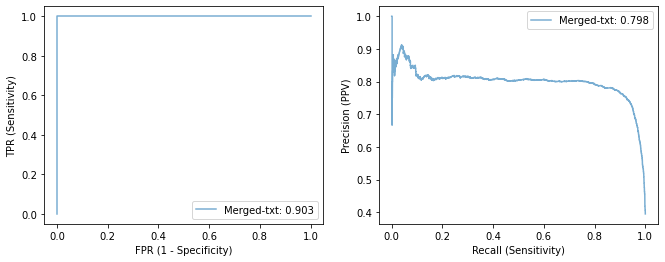

In [24]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

f, axarr = plt.subplots(1, 2, figsize=(11, 4))

model_name = "Merged-txt"
fpr, tpr, _ = roc_curve(yt, yt)
precisions, recalls, _ = precision_recall_curve(yt, yp)
auroc = roc_auc_score(yt, yp)
auprc = average_precision_score(yt, yp)
preds = (yp >= 0.5).astype(int)
f1 = f1_score(yt, preds)
print(f"{model_name} f1: {f1:.3f}")
axarr[0].plot(fpr, tpr, alpha=0.6, label=f'{model_name}: {auroc:.3f}')
axarr[1].step(recalls, precisions, where='post', alpha=0.6, label=f'{model_name}: {auprc:.3f}')


axarr[0].legend()
axarr[0].set_xlabel('FPR (1 - Specificity)')
axarr[0].set_ylabel('TPR (Sensitivity)')
axarr[1].legend()
axarr[1].set_xlabel('Recall (Sensitivity)')
axarr[1].set_ylabel('Precision (PPV)')

### triage 

In [25]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(
    triage_dataset_cc['train'], shuffle = True, batch_size = 1, collate_fn = data_collator
)

eval_dataloader = DataLoader(
    triage_dataset_cc['valid'], shuffle = True, collate_fn = data_collator
)

In [26]:
for epoch in range(num_epoch):
    model_task_specific.train()
    for batch in train_dataloader:
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model_task_specific(**batch)
        loss = outputs.loss
        loss.backward() # computes gradients
        
        optimizer.step() # updates the weights and biases based on these gradients
        lr_scheduler.step() # updates the weights and biases based on these gradients
        optimizer.zero_grad() # used to clear the gradients of all parameters in a model
        # progress_bar_train.update(1)
    print("epoch training", str(epoch), "done")
    print("loss:", str(loss))
    
    # run on validation set
    model_task_specific.eval()
    for batch in eval_dataloader:
        batch = { k: v.to(device) for k, v in batch.items() }
        with torch.no_grad(): # a context manager that disables gradient calculation during model inference
            outputs = model_task_specific(**batch)
            
        logits = outputs.logits # calculates the probabilities between the labels
        predictions = torch.argmax(logits, dim = -1 ) # takes the label closest to 1
        metric.add_batch(predictions = predictions, references = batch['labels'] ) 
        # progress_bar_eval.update(1)
        
    print(metric.compute()) 


  0%|          | 0/28001 [22:51<?, ?it/s]


  0%|          | 0/6000 [22:51<?, ?it/s]


epoch training 0 done
loss: tensor(0.5953, device='cuda:0', grad_fn=<NllLossBackward0>)
{'f1': 0.4951892238614496}


In [27]:
probs_list = []
label_list = []
logits_list = []

test_dataloader = DataLoader(
    triage_dataset_cc['test'], batch_size = 4, collate_fn = data_collator
)    


metric = load_metric("f1", "precision")

for i, batch in enumerate(test_dataloader):
    batch = { k: v.to(device) for k, v in batch.items() }
    with torch.no_grad(): # a context manager that disables gradient calculation during model inference
        outputs = model_task_specific(**batch)

    logits = outputs.logits # calculates the probabilities between the labels
    probs_list.append(torch.sigmoid(logits[:, 1]).cpu().detach().numpy())
    logits_list.append(logits[:, 1].cpu().detach().numpy())
    label_list.append(batch['labels'].cpu().detach().numpy())
    predictions = torch.argmax(logits, dim = -1 ) # takes the label closest to 1
    metric.add_batch(predictions = predictions, references = batch['labels'] )
    # print("New Batch")
    # print(predictions)
    # print(batch['labels'])

print(metric.compute()) 

{'f1': 0.49888428434810334}


Merged-txt f1: 0.566


Text(0, 0.5, 'Precision (PPV)')

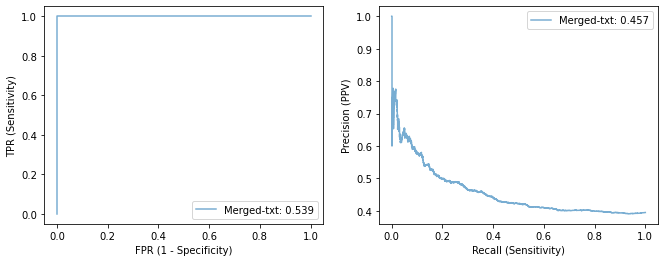

In [29]:
from sklearn.metrics import roc_auc_score, average_precision_score
yt = np.hstack(label_list) 
yl = np.hstack(logits_list)
yp = np.hstack(probs_list)

result_df = pd.DataFrame({"y_true": yt, "y_prob": yp, "y_raw": yl})
result_df.to_csv('Finetune-triage.csv')

f, axarr = plt.subplots(1, 2, figsize=(11, 4))

model_name = "Merged-txt"
fpr, tpr, _ = roc_curve(yt, yt)
precisions, recalls, _ = precision_recall_curve(yt, yp)
auroc = roc_auc_score(yt, yp)
auprc = average_precision_score(yt, yp)
preds = (yp >= 0.5).astype(int)
f1 = f1_score(yt, preds)
print(f"{model_name} f1: {f1:.3f}")
axarr[0].plot(fpr, tpr, alpha=0.6, label=f'{model_name}: {auroc:.3f}')
axarr[1].step(recalls, precisions, where='post', alpha=0.6, label=f'{model_name}: {auprc:.3f}')


axarr[0].legend()
axarr[0].set_xlabel('FPR (1 - Specificity)')
axarr[0].set_ylabel('TPR (Sensitivity)')
axarr[1].legend()
axarr[1].set_xlabel('Recall (Sensitivity)')
axarr[1].set_ylabel('Precision (PPV)')

### Medrecon

In [30]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(
    medrecon_dataset_cc['train'], shuffle = True, batch_size = 1, collate_fn = data_collator
)

eval_dataloader = DataLoader(
    medrecon_dataset_cc['valid'], shuffle = True, collate_fn = data_collator
)

for epoch in range(num_epoch):
    model_task_specific.train()
    for batch in train_dataloader:
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model_task_specific(**batch)
        loss = outputs.loss
        loss.backward() # computes gradients
        
        optimizer.step() # updates the weights and biases based on these gradients
        lr_scheduler.step() # updates the weights and biases based on these gradients
        optimizer.zero_grad() # used to clear the gradients of all parameters in a model
        # progress_bar_train.update(1)
    print("epoch training", str(epoch), "done")
    print("loss:", str(loss))
    
    # run on validation set
    model_task_specific.eval()
    for batch in eval_dataloader:
        batch = { k: v.to(device) for k, v in batch.items() }
        with torch.no_grad(): # a context manager that disables gradient calculation during model inference
            outputs = model_task_specific(**batch)
            
        logits = outputs.logits # calculates the probabilities between the labels
        predictions = torch.argmax(logits, dim = -1 ) # takes the label closest to 1
        metric.add_batch(predictions = predictions, references = batch['labels'] ) 
        # progress_bar_eval.update(1)
        
    print(metric.compute()) 

epoch training 0 done
loss: tensor(0.7731, device='cuda:0', grad_fn=<NllLossBackward0>)
{'f1': 0.46836329675461125}


In [31]:
probs_list = []
label_list = []
logits_list = []

test_dataloader = DataLoader(
    medrecon_dataset_cc['test'], batch_size = 4, collate_fn = data_collator
)    


metric = load_metric("f1", "precision")

for i, batch in enumerate(test_dataloader):
    batch = { k: v.to(device) for k, v in batch.items() }
    with torch.no_grad(): # a context manager that disables gradient calculation during model inference
        outputs = model_task_specific(**batch)

    logits = outputs.logits # calculates the probabilities between the labels
    probs_list.append(torch.sigmoid(logits[:, 1]).cpu().detach().numpy())
    logits_list.append(logits[:, 1].cpu().detach().numpy())
    label_list.append(batch['labels'].cpu().detach().numpy())
    predictions = torch.argmax(logits, dim = -1 ) # takes the label closest to 1
    metric.add_batch(predictions = predictions, references = batch['labels'] )
    # print("New Batch")
    # print(predictions)
    # print(batch['labels'])

print(metric.compute()) 

{'f1': 0.4830783495595735}


Merged-txt f1: 0.567


Text(0, 0.5, 'Precision (PPV)')

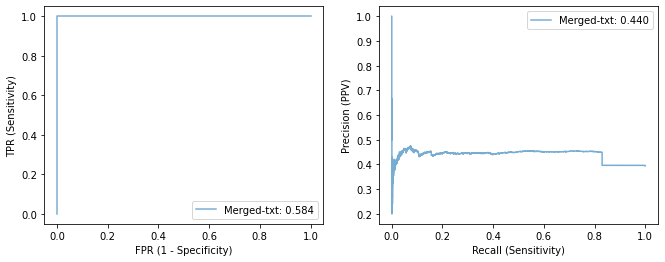

In [32]:
from sklearn.metrics import roc_auc_score, average_precision_score
yt = np.hstack(label_list) 
yl = np.hstack(logits_list)
yp = np.hstack(probs_list)

result_df = pd.DataFrame({"y_true": yt, "y_prob": yp, "y_raw": yl})
result_df.to_csv('Finetune-medrecon.csv')

f, axarr = plt.subplots(1, 2, figsize=(11, 4))

model_name = "Merged-txt"
fpr, tpr, _ = roc_curve(yt, yt)
precisions, recalls, _ = precision_recall_curve(yt, yp)
auroc = roc_auc_score(yt, yp)
auprc = average_precision_score(yt, yp)
preds = (yp >= 0.5).astype(int)
f1 = f1_score(yt, preds)
print(f"{model_name} f1: {f1:.3f}")
axarr[0].plot(fpr, tpr, alpha=0.6, label=f'{model_name}: {auroc:.3f}')
axarr[1].step(recalls, precisions, where='post', alpha=0.6, label=f'{model_name}: {auprc:.3f}')


axarr[0].legend()
axarr[0].set_xlabel('FPR (1 - Specificity)')
axarr[0].set_ylabel('TPR (Sensitivity)')
axarr[1].legend()
axarr[1].set_xlabel('Recall (Sensitivity)')
axarr[1].set_ylabel('Precision (PPV)')

### vitals

In [33]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(
    vitals_dataset_cc['train'], shuffle = True, batch_size = 1, collate_fn = data_collator
)

eval_dataloader = DataLoader(
    vitals_dataset_cc['valid'], shuffle = True, collate_fn = data_collator
)

for epoch in range(num_epoch):
    model_task_specific.train()
    for batch in train_dataloader:
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model_task_specific(**batch)
        loss = outputs.loss
        loss.backward() # computes gradients
        
        optimizer.step() # updates the weights and biases based on these gradients
        lr_scheduler.step() # updates the weights and biases based on these gradients
        optimizer.zero_grad() # used to clear the gradients of all parameters in a model
        # progress_bar_train.update(1)
    print("epoch training", str(epoch), "done")
    print("loss:", str(loss))
    
    # run on validation set
    model_task_specific.eval()
    for batch in eval_dataloader:
        batch = { k: v.to(device) for k, v in batch.items() }
        with torch.no_grad(): # a context manager that disables gradient calculation during model inference
            outputs = model_task_specific(**batch)
            
        logits = outputs.logits # calculates the probabilities between the labels
        predictions = torch.argmax(logits, dim = -1 ) # takes the label closest to 1
        metric.add_batch(predictions = predictions, references = batch['labels'] ) 
        # progress_bar_eval.update(1)
        
    print(metric.compute()) 

epoch training 0 done
loss: tensor(0.5865, device='cuda:0', grad_fn=<NllLossBackward0>)
{'f1': 0.3405039950829748}


In [34]:
probs_list = []
label_list = []
logits_list = []

test_dataloader = DataLoader(
    vitals_dataset_cc['test'], batch_size = 4, collate_fn = data_collator
)    


metric = load_metric("f1", "precision")

for i, batch in enumerate(test_dataloader):
    batch = { k: v.to(device) for k, v in batch.items() }
    with torch.no_grad(): # a context manager that disables gradient calculation during model inference
        outputs = model_task_specific(**batch)

    logits = outputs.logits # calculates the probabilities between the labels
    probs_list.append(torch.sigmoid(logits[:, 1]).cpu().detach().numpy())
    logits_list.append(logits[:, 1].cpu().detach().numpy())
    label_list.append(batch['labels'].cpu().detach().numpy())
    predictions = torch.argmax(logits, dim = -1 ) # takes the label closest to 1
    metric.add_batch(predictions = predictions, references = batch['labels'] )
    # print("New Batch")
    # print(predictions)
    # print(batch['labels'])

print(metric.compute()) 

{'f1': 0.32473910374462855}


Merged-txt f1: 0.566


Text(0, 0.5, 'Precision (PPV)')

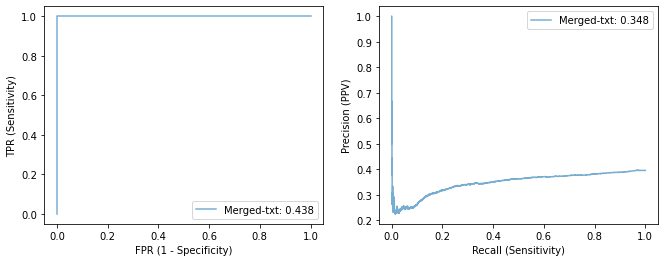

In [35]:
from sklearn.metrics import roc_auc_score, average_precision_score
yt = np.hstack(label_list) 
yl = np.hstack(logits_list)
yp = np.hstack(probs_list)

result_df = pd.DataFrame({"y_true": yt, "y_prob": yp, "y_raw": yl})
result_df.to_csv('Finetune-vitals.csv')

f, axarr = plt.subplots(1, 2, figsize=(11, 4))

model_name = "Merged-txt"
fpr, tpr, _ = roc_curve(yt, yt)
precisions, recalls, _ = precision_recall_curve(yt, yp)
auroc = roc_auc_score(yt, yp)
auprc = average_precision_score(yt, yp)
preds = (yp >= 0.5).astype(int)
f1 = f1_score(yt, preds)
print(f"{model_name} f1: {f1:.3f}")
axarr[0].plot(fpr, tpr, alpha=0.6, label=f'{model_name}: {auroc:.3f}')
axarr[1].step(recalls, precisions, where='post', alpha=0.6, label=f'{model_name}: {auprc:.3f}')


axarr[0].legend()
axarr[0].set_xlabel('FPR (1 - Specificity)')
axarr[0].set_ylabel('TPR (Sensitivity)')
axarr[1].legend()
axarr[1].set_xlabel('Recall (Sensitivity)')
axarr[1].set_ylabel('Precision (PPV)')

### codes

In [36]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(
    codes_dataset_cc['train'], shuffle = True, batch_size = 1, collate_fn = data_collator
)

eval_dataloader = DataLoader(
    codes_dataset_cc['valid'], shuffle = True, collate_fn = data_collator
)

for epoch in range(num_epoch):
    model_task_specific.train()
    for batch in train_dataloader:
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model_task_specific(**batch)
        loss = outputs.loss
        loss.backward() # computes gradients
        
        optimizer.step() # updates the weights and biases based on these gradients
        lr_scheduler.step() # updates the weights and biases based on these gradients
        optimizer.zero_grad() # used to clear the gradients of all parameters in a model
        # progress_bar_train.update(1)
    print("epoch training", str(epoch), "done")
    print("loss:", str(loss))
    
    # run on validation set
    model_task_specific.eval()
    for batch in eval_dataloader:
        batch = { k: v.to(device) for k, v in batch.items() }
        with torch.no_grad(): # a context manager that disables gradient calculation during model inference
            outputs = model_task_specific(**batch)
            
        logits = outputs.logits # calculates the probabilities between the labels
        predictions = torch.argmax(logits, dim = -1 ) # takes the label closest to 1
        metric.add_batch(predictions = predictions, references = batch['labels'] ) 
        # progress_bar_eval.update(1)
        
    print(metric.compute()) 

epoch training 0 done
loss: tensor(0.6887, device='cuda:0', grad_fn=<NllLossBackward0>)
{'f1': 0.0008435259384226066}


In [37]:
probs_list = []
label_list = []
logits_list = []

test_dataloader = DataLoader(
    codes_dataset_cc['test'], batch_size = 4, collate_fn = data_collator
)    


metric = load_metric("f1", "precision")

for i, batch in enumerate(test_dataloader):
    batch = { k: v.to(device) for k, v in batch.items() }
    with torch.no_grad(): # a context manager that disables gradient calculation during model inference
        outputs = model_task_specific(**batch)

    logits = outputs.logits # calculates the probabilities between the labels
    probs_list.append(torch.sigmoid(logits[:, 1]).cpu().detach().numpy())
    logits_list.append(logits[:, 1].cpu().detach().numpy())
    label_list.append(batch['labels'].cpu().detach().numpy())
    predictions = torch.argmax(logits, dim = -1 ) # takes the label closest to 1
    metric.add_batch(predictions = predictions, references = batch['labels'] )
    # print("New Batch")
    # print(predictions)
    # print(batch['labels'])

print(metric.compute()) 

{'f1': 0.0008385744234800838}


Merged-txt f1: 0.418


Text(0, 0.5, 'Precision (PPV)')

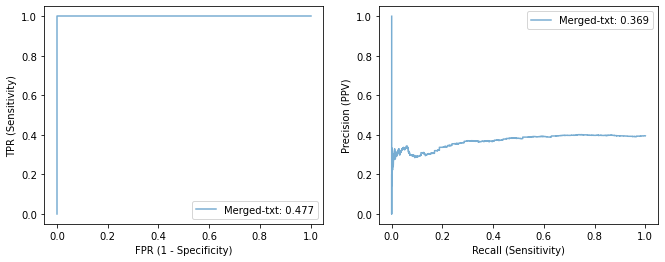

In [38]:
from sklearn.metrics import roc_auc_score, average_precision_score
yt = np.hstack(label_list) 
yl = np.hstack(logits_list)
yp = np.hstack(probs_list)

result_df = pd.DataFrame({"y_true": yt, "y_prob": yp, "y_raw": yl})
result_df.to_csv('Finetune-codes.csv')

f, axarr = plt.subplots(1, 2, figsize=(11, 4))

model_name = "Merged-txt"
fpr, tpr, _ = roc_curve(yt, yt)
precisions, recalls, _ = precision_recall_curve(yt, yp)
auroc = roc_auc_score(yt, yp)
auprc = average_precision_score(yt, yp)
preds = (yp >= 0.5).astype(int)
f1 = f1_score(yt, preds)
print(f"{model_name} f1: {f1:.3f}")
axarr[0].plot(fpr, tpr, alpha=0.6, label=f'{model_name}: {auroc:.3f}')
axarr[1].step(recalls, precisions, where='post', alpha=0.6, label=f'{model_name}: {auprc:.3f}')


axarr[0].legend()
axarr[0].set_xlabel('FPR (1 - Specificity)')
axarr[0].set_ylabel('TPR (Sensitivity)')
axarr[1].legend()
axarr[1].set_xlabel('Recall (Sensitivity)')
axarr[1].set_ylabel('Precision (PPV)')

### pyxis

In [39]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_dataloader = DataLoader(
    pyxis_dataset_cc['train'], shuffle = True, batch_size = 1, collate_fn = data_collator
)

eval_dataloader = DataLoader(
    pyxis_dataset_cc['valid'], shuffle = True, collate_fn = data_collator
)

for epoch in range(num_epoch):
    model_task_specific.train()
    for batch in train_dataloader:
        batch = { k: v.to(device) for k, v in batch.items() }
        outputs = model_task_specific(**batch)
        loss = outputs.loss
        loss.backward() # computes gradients
        
        optimizer.step() # updates the weights and biases based on these gradients
        lr_scheduler.step() # updates the weights and biases based on these gradients
        optimizer.zero_grad() # used to clear the gradients of all parameters in a model
        # progress_bar_train.update(1)
    print("epoch training", str(epoch), "done")
    print("loss:", str(loss))
    
    # run on validation set
    model_task_specific.eval()
    for batch in eval_dataloader:
        batch = { k: v.to(device) for k, v in batch.items() }
        with torch.no_grad(): # a context manager that disables gradient calculation during model inference
            outputs = model_task_specific(**batch)
            
        logits = outputs.logits # calculates the probabilities between the labels
        predictions = torch.argmax(logits, dim = -1 ) # takes the label closest to 1
        metric.add_batch(predictions = predictions, references = batch['labels'] ) 
        # progress_bar_eval.update(1)
        
    print(metric.compute()) 

epoch training 0 done
loss: tensor(0.7074, device='cuda:0', grad_fn=<NllLossBackward0>)
{'f1': 0.066030230708035}


In [40]:
probs_list = []
label_list = []
logits_list = []

test_dataloader = DataLoader(
    pyxis_dataset_cc['test'], batch_size = 4, collate_fn = data_collator
)    


metric = load_metric("f1", "precision")

for i, batch in enumerate(test_dataloader):
    batch = { k: v.to(device) for k, v in batch.items() }
    with torch.no_grad(): # a context manager that disables gradient calculation during model inference
        outputs = model_task_specific(**batch)

    logits = outputs.logits # calculates the probabilities between the labels
    probs_list.append(torch.sigmoid(logits[:, 1]).cpu().detach().numpy())
    logits_list.append(logits[:, 1].cpu().detach().numpy())
    label_list.append(batch['labels'].cpu().detach().numpy())
    predictions = torch.argmax(logits, dim = -1 ) # takes the label closest to 1
    metric.add_batch(predictions = predictions, references = batch['labels'] )
    # print("New Batch")
    # print(predictions)
    # print(batch['labels'])

print(metric.compute()) 

{'f1': 0.0495603517186251}


Merged-txt f1: 0.564


Text(0, 0.5, 'Precision (PPV)')

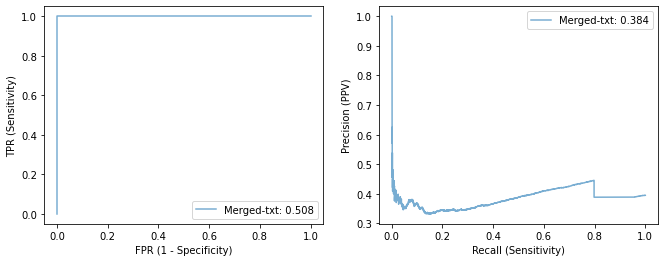

In [41]:
yt = np.hstack(label_list) 
yl = np.hstack(logits_list)
yp = np.hstack(probs_list)

result_df = pd.DataFrame({"y_true": yt, "y_prob": yp, "y_raw": yl})
result_df.to_csv('Finetune-pyxis.csv')

f, axarr = plt.subplots(1, 2, figsize=(11, 4))

model_name = "Merged-txt"
fpr, tpr, _ = roc_curve(yt, yt)
precisions, recalls, _ = precision_recall_curve(yt, yp)
auroc = roc_auc_score(yt, yp)
auprc = average_precision_score(yt, yp)
preds = (yp >= 0.5).astype(int)
f1 = f1_score(yt, preds)
print(f"{model_name} f1: {f1:.3f}")
axarr[0].plot(fpr, tpr, alpha=0.6, label=f'{model_name}: {auroc:.3f}')
axarr[1].step(recalls, precisions, where='post', alpha=0.6, label=f'{model_name}: {auprc:.3f}')


axarr[0].legend()
axarr[0].set_xlabel('FPR (1 - Specificity)')
axarr[0].set_ylabel('TPR (Sensitivity)')
axarr[1].legend()
axarr[1].set_xlabel('Recall (Sensitivity)')
axarr[1].set_ylabel('Precision (PPV)')

# Multiple Modality

In [42]:
train_dataloader_concat = [triage_dataset_cc["train"], arrival_dataset_cc["train"],medrecon_dataset_cc["train"],vitals_dataset_cc["train"],codes_dataset_cc["train"],pyxis_dataset_cc["train"]]
valid_dataloader_concat = [triage_dataset_cc["valid"], arrival_dataset_cc["valid"],medrecon_dataset_cc["valid"],vitals_dataset_cc["valid"],codes_dataset_cc["valid"],pyxis_dataset_cc["valid"]]
test_dataloader_concat = [triage_dataset_cc["test"], arrival_dataset_cc["test"],medrecon_dataset_cc["test"],vitals_dataset_cc["test"],codes_dataset_cc["test"],pyxis_dataset_cc["test"]]

In [47]:
# TRAINING LOOP

num_epoch=1
BATCH = 4
from tqdm.auto import tqdm
progress_bar_train = tqdm(range(num_epoch * len(triage_dataset_cc['train']["input_ids"]) // BATCH ))
# progress_bar_train = tqdm(range(num_training_steps))
progress_bar_eval = tqdm(range(num_epoch * len(triage_dataset_cc['valid']["input_ids"]) // BATCH ))

for epoch in range(num_epoch):
    full_model.train()
    print(f"Epoch {epoch}...")
    random_idx = np.random.permutation(np.arange(len(train_dataloader_concat[0]['input_ids'])))
    # for i, b in tqdm(enumerate(train_dl)):
    for step, idx in enumerate(range(0, len(random_idx), BATCH)):
        iter_rand_idx = random_idx[idx:idx+BATCH]
        input_ids, attention_mask = [], []
        for modality in train_dataloader_concat:
            input_ids.append(modality['input_ids'][iter_rand_idx].to(device))
            attention_mask.append(modality['attention_mask'][iter_rand_idx].to(device))
        label = modality['label'][iter_rand_idx].to(device)
        outputs = full_model(input_ids, attention_mask, label)
#         unified_embedding = torch.cat((embedding[0],embedding[1],embedding[2],embedding[3],embedding[4],embedding[5]),1) # concatenates embeddings on the second dimension
#         outputs = predictor(unified_embedding, modality['label'][i:i+BATCH].to(device))
        # updates weights accordingly
        loss = outputs.loss
        loss.backward() # computes gradients

        optimizer.step() # updates the weights and biases based on these gradients
        lr_scheduler.step() # updates the weights and biases based on these gradients
        optimizer.zero_grad() # used to clear the gradients of all parameters in a model
        progress_bar_train.update(1)
    
    # # run on validation set
    print("Validation")
    full_model.eval()
    # for i, b in tqdm(enumerate(train_dl)):
    for step, idx in enumerate(range(0, len(valid_dataloader_concat[0]['input_ids']), BATCH)):
        input_ids, attention_mask = [], []
        for modality in valid_dataloader_concat:
            input_ids.append(modality['input_ids'][idx:idx+BATCH].to(device))
            attention_mask.append(modality['attention_mask'][idx:idx+BATCH].to(device))
        label = modality['label'][idx:idx+BATCH].to(device)
        with torch.no_grad():
            outputs = full_model(input_ids, attention_mask, label)
        logits = outputs.logits # calculates the probabilities between the labels
        predictions = torch.argmax(logits, dim = -1 ) # takes the label closest to 1
        metric.add_batch(predictions = predictions, references = label) 
        loss = outputs.loss
        progress_bar_eval.update(1)
    
    print(metric.compute())
    
    # # add some model.save()
    

  0%|          | 73/28001 [3:28:31<1329:37:36, 171.39s/it]

  0%|          | 0/6000 [3:28:31<?, ?it/s]A


Epoch 0...


  0%|          | 34/7000 [00:30<1:44:45,  1.11it/s]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ <ipython-input-47-cbbfc3a913a7>:19 in <module>                                                   │
│                                                                                                  │
│ /opt/conda/lib/python3.9/site-packages/datasets/arrow_dataset.py:2803 in __getitem__             │
│                                                                                                  │
│   2800 │                                                                                         │
│   2801 │   def __getitem__(self, key):  # noqa: F811                                             │
│   2802 │   │   """Can be used to index columns (by string names) or rows (by integer index or i  │
│ ❱ 2803 │   │   return self._getitem(key)                                                         │
│   2804 │                                                                                         │
│   2805 │   def __getitems__(self, keys: List) -> List:                                           │
│   2806 │   │   """Can be used to get a batch using a list of integers indices."""                │
│                                                                                                  │
│ /opt/conda/lib/python3.9/site-packages/datasets/arrow_dataset.py:2788 in _getitem                │
│                                                                                                  │
│   2785 │   │   format_kwargs = format_kwargs if format_kwargs is not None else {}                │
│   2786 │   │   formatter = get_formatter(format_type, features=self._info.features, **format_kw  │
│   2787 │   │   pa_subtable = query_table(self._data, key, indices=self._indices if self._indice  │
│ ❱ 2788 │   │   formatted_output = format_table(                                                  │
│   2789 │   │   │   pa_subtable, key, formatter=formatter, format_columns=format_columns, output  │
│   2790 │   │   )                                                                                 │
│   2791 │   │   return formatted_output                                                           │
│                                                                                                  │
│ /opt/conda/lib/python3.9/site-packages/datasets/formatting/formatting.py:632 in format_table     │
│                                                                                                  │
│   629 │   │   return formatter(pa_table, query_type=query_type)                                  │
│   630 │   elif query_type == "column":                                                           │
│   631 │   │   if key in format_columns:                                                          │
│ ❱ 632 │   │   │   return formatter(pa_table, query_type)                                         │
│   633 │   │   else:                                                                              │
│   634 │   │   │   return python_formatter(pa_table, query_type=query_type)                       │
│   635 │   else:                                                                                  │
│                                                                                                  │
│ /opt/conda/lib/python3.9/site-packages/datasets/formatting/formatting.py:398 in __call__         │
│                                                                                                  │
│   395 │   │   if query_type == "row":                                                            │
│   396 │   │   │   return self.format_row(pa_table)                                               │
│   397 │   │   elif query_type == "column":                                                       │
│ ❱ 398 │   │   │   return self.format_column(pa_table)                                            │
│   399 │   │   elif query_type == "batch":                  

# Test predictions

In [ ]:
logit_list = []
label_list = []
probs_list = []

full_model.eval()
for step, idx in tqdm(enumerate(range(0, len(test_dataloader_concat[0]['input_ids']), BATCH))):
    input_ids, attention_mask = [], []
    for modality in test_dataloader_concat:
        input_ids.append(modality['input_ids'][idx:idx+BATCH].to(device))
        attention_mask.append(modality['attention_mask'][idx:idx+BATCH].to(device))
    label = modality['label'][idx:idx+BATCH].to(device)
    with torch.no_grad():
        outputs = full_model(input_ids, attention_mask, label)
    logits = outputs.logits # calculates the probabilities between the labels
    predictions = torch.argmax(logits, dim = -1 ) # takes the label closest to 1
    loss = outputs.loss
    logits = outputs.logits # calculates the probabilities between the labels
    logit_list.append(logits[:, 1].cpu().detach().numpy())
    label_list.append(label.cpu().detach().numpy())
    probs_list.append(torch.sigmoid(logits[:, 1]).cpu().detach().numpy())
    predictions = torch.argmax(logits, dim = -1 ) # takes the label closest to 1
    metric.add_batch(predictions = predictions, references = label)
    # print("New Batch")
    # print(predictions)
    # print(modality['label'][i:i+BATCH])

print(metric.compute()) 

In [ ]:
print("what")